# Análisis descriptivo y gráfico

In [1]:
# Tratamiento base de datos
import pandas as pd

# Gráficos
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm, normaltest
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Esconder warnings
import warnings
warnings.filterwarnings('ignore')

# Acceso a directorios
from os import listdir
from os.path import isfile, join

## 1. Selección de la apertura del Order Book

In [2]:
# Read csv
midprice = pd.read_csv('datos/midprice.csv')

# Fecha a datetime
midprice['date'] = pd.to_datetime(midprice['date'])

# Extraemos los minutos
midprice['minute'] = pd.DatetimeIndex(midprice['date']).minute

In [3]:
# Comprobamos los valores únicos en las diferencias de minuto. Buscamos una sección que sólo contenga 1 y -59
np.unique(np.diff(midprice['minute']), return_index = True)

(array([-59, -29, -21,   1,   2,   4,  19,  24,  27], dtype=int64),
 array([   13, 12268, 18210,     0, 11428, 12004,  2454, 12136, 31064],
       dtype=int64))

In [4]:
# Índice 2455:11429
SubSetMidPrice = midprice.iloc[2455:11429, :]

In [5]:
# Comprobamos que sólo aparece una diferencia de 1 o de 59 (al cambiar de día)
np.unique(np.diff(SubSetMidPrice['minute']), return_index = True)

(array([-59,   1], dtype=int64), array([0, 1], dtype=int64))

In [6]:
# Comprobamos las fechas
SubSetMidPrice

,date,MPT0,minute
2455,2021-05-08 18:59:31,58373.02,59
2456,2021-05-08 19:00:32,58464.31,0
2457,2021-05-08 19:01:32,58364.54,1
2458,2021-05-08 19:02:31,58323.24,2
2459,2021-05-08 19:03:31,58294.58,3
...,...,...,...
11424,2021-05-15 00:28:31,49837.81,28
11425,2021-05-15 00:29:31,49886.66,29
11426,2021-05-15 00:30:31,50008.68,30
11427,2021-05-15 00:31:31,50025.82,31


In [7]:
# PCT Change
SubSetMidPrice['PctChange_1minute'] = SubSetMidPrice['MPT0'].pct_change() * 100

In [8]:
SubSetMidPrice

,date,MPT0,minute,PctChange_1minute
2455,2021-05-08 18:59:31,58373.02,59,NaN
2456,2021-05-08 19:00:32,58464.31,0,0.156391
2457,2021-05-08 19:01:32,58364.54,1,-0.170651
2458,2021-05-08 19:02:31,58323.24,2,-0.070762
2459,2021-05-08 19:03:31,58294.58,3,-0.049140
...,...,...,...,...
11424,2021-05-15 00:28:31,49837.81,28,-0.021846
11425,2021-05-15 00:29:31,49886.66,29,0.098018
11426,2021-05-15 00:30:31,50008.68,30,0.244594
11427,2021-05-15 00:31:31,50025.82,31,0.034274


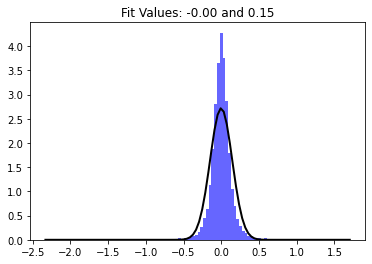

In [9]:
mu, std = norm.fit(SubSetMidPrice['PctChange_1minute'][1:]) 

# Plot the histogram.
plt.hist(SubSetMidPrice['PctChange_1minute'][1:], bins=100, density=True, alpha=0.6, color='b')

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)

plt.plot(x, p, 'k', linewidth=2)
title = "Fit Values: {:.2f} and {:.2f}".format(mu, std)
plt.title(title)
  
plt.show()

In [10]:
# No es normal
normaltest(SubSetMidPrice['PctChange_1minute'][1:])

NormaltestResult(statistic=3468.7128124876476, pvalue=0.0)

In [11]:
vol = round(SubSetMidPrice['PctChange_1minute'].std(), 2)
min5 = round(SubSetMidPrice['PctChange_1minute'].std() * np.sqrt(5), 2)
hora1 = round(SubSetMidPrice['PctChange_1minute'].std() * np.sqrt(60), 2)
dia1 = round(SubSetMidPrice['PctChange_1minute'].std() * np.sqrt(1440), 2)

In [12]:
print('Volatilidad media en el mercado: ', vol)

print('Volatilidad media en el mercado a 5 minutos: ', min5, ' --> 5 sigmas: ', round(min5 * 5, 2))

print('Volatilidad media en el mercado a 1 hora: ', hora1, ' --> 5 sigmas: ', round(hora1 * 5, 2))

print('Volatilidad media en el mercado a 1 día: ', dia1, ' --> 5 sigmas: ', round(dia1 * 5, 2))

Volatilidad media en el mercado:  0.15
Volatilidad media en el mercado a 5 minutos:  0.33  --> 5 sigmas:  1.65
Volatilidad media en el mercado a 1 hora:  1.14  --> 5 sigmas:  5.7
Volatilidad media en el mercado a 1 día:  5.57  --> 5 sigmas:  27.85


# 2. Análisis gráfico

## 2.1. Jitter Plot

In [13]:
# ======================== #
# Order Book Files Bitcoin #
# ======================== #

obBtc = 'C:/Users/victo/Desktop/UNIVERSIDAD/MASTER/TFM/Order_Book/BTCBUSD'
obBtcFiles = [f for f in listdir(obBtc) if isfile(join(obBtc, f))]

In [14]:
def jitterPlot(a, b, indices, c = 1):

    li = []

    for i in range(a, b, c):
        df_ObBtc = pd.read_feather('Order_Book/BTCBUSD/' + obBtcFiles[i])
    
        li.append(df_ObBtc.iloc[indices])
    
    df = pd.concat(li, axis = 0, ignore_index = True)

    # b'bids', b'2021-04-30, 13:24:51', b'BTCBUSD'
    clms = ['side', 'date', 'crpt']
    
    for cl in clms:
        df[cl] = df[cl].str.decode('utf-8')

    g = sns.stripplot(x = "date", y = "price", hue = 'side', data = df)
    g.set_xticklabels(labels = df['date'], rotation = 30, fontsize = 10)

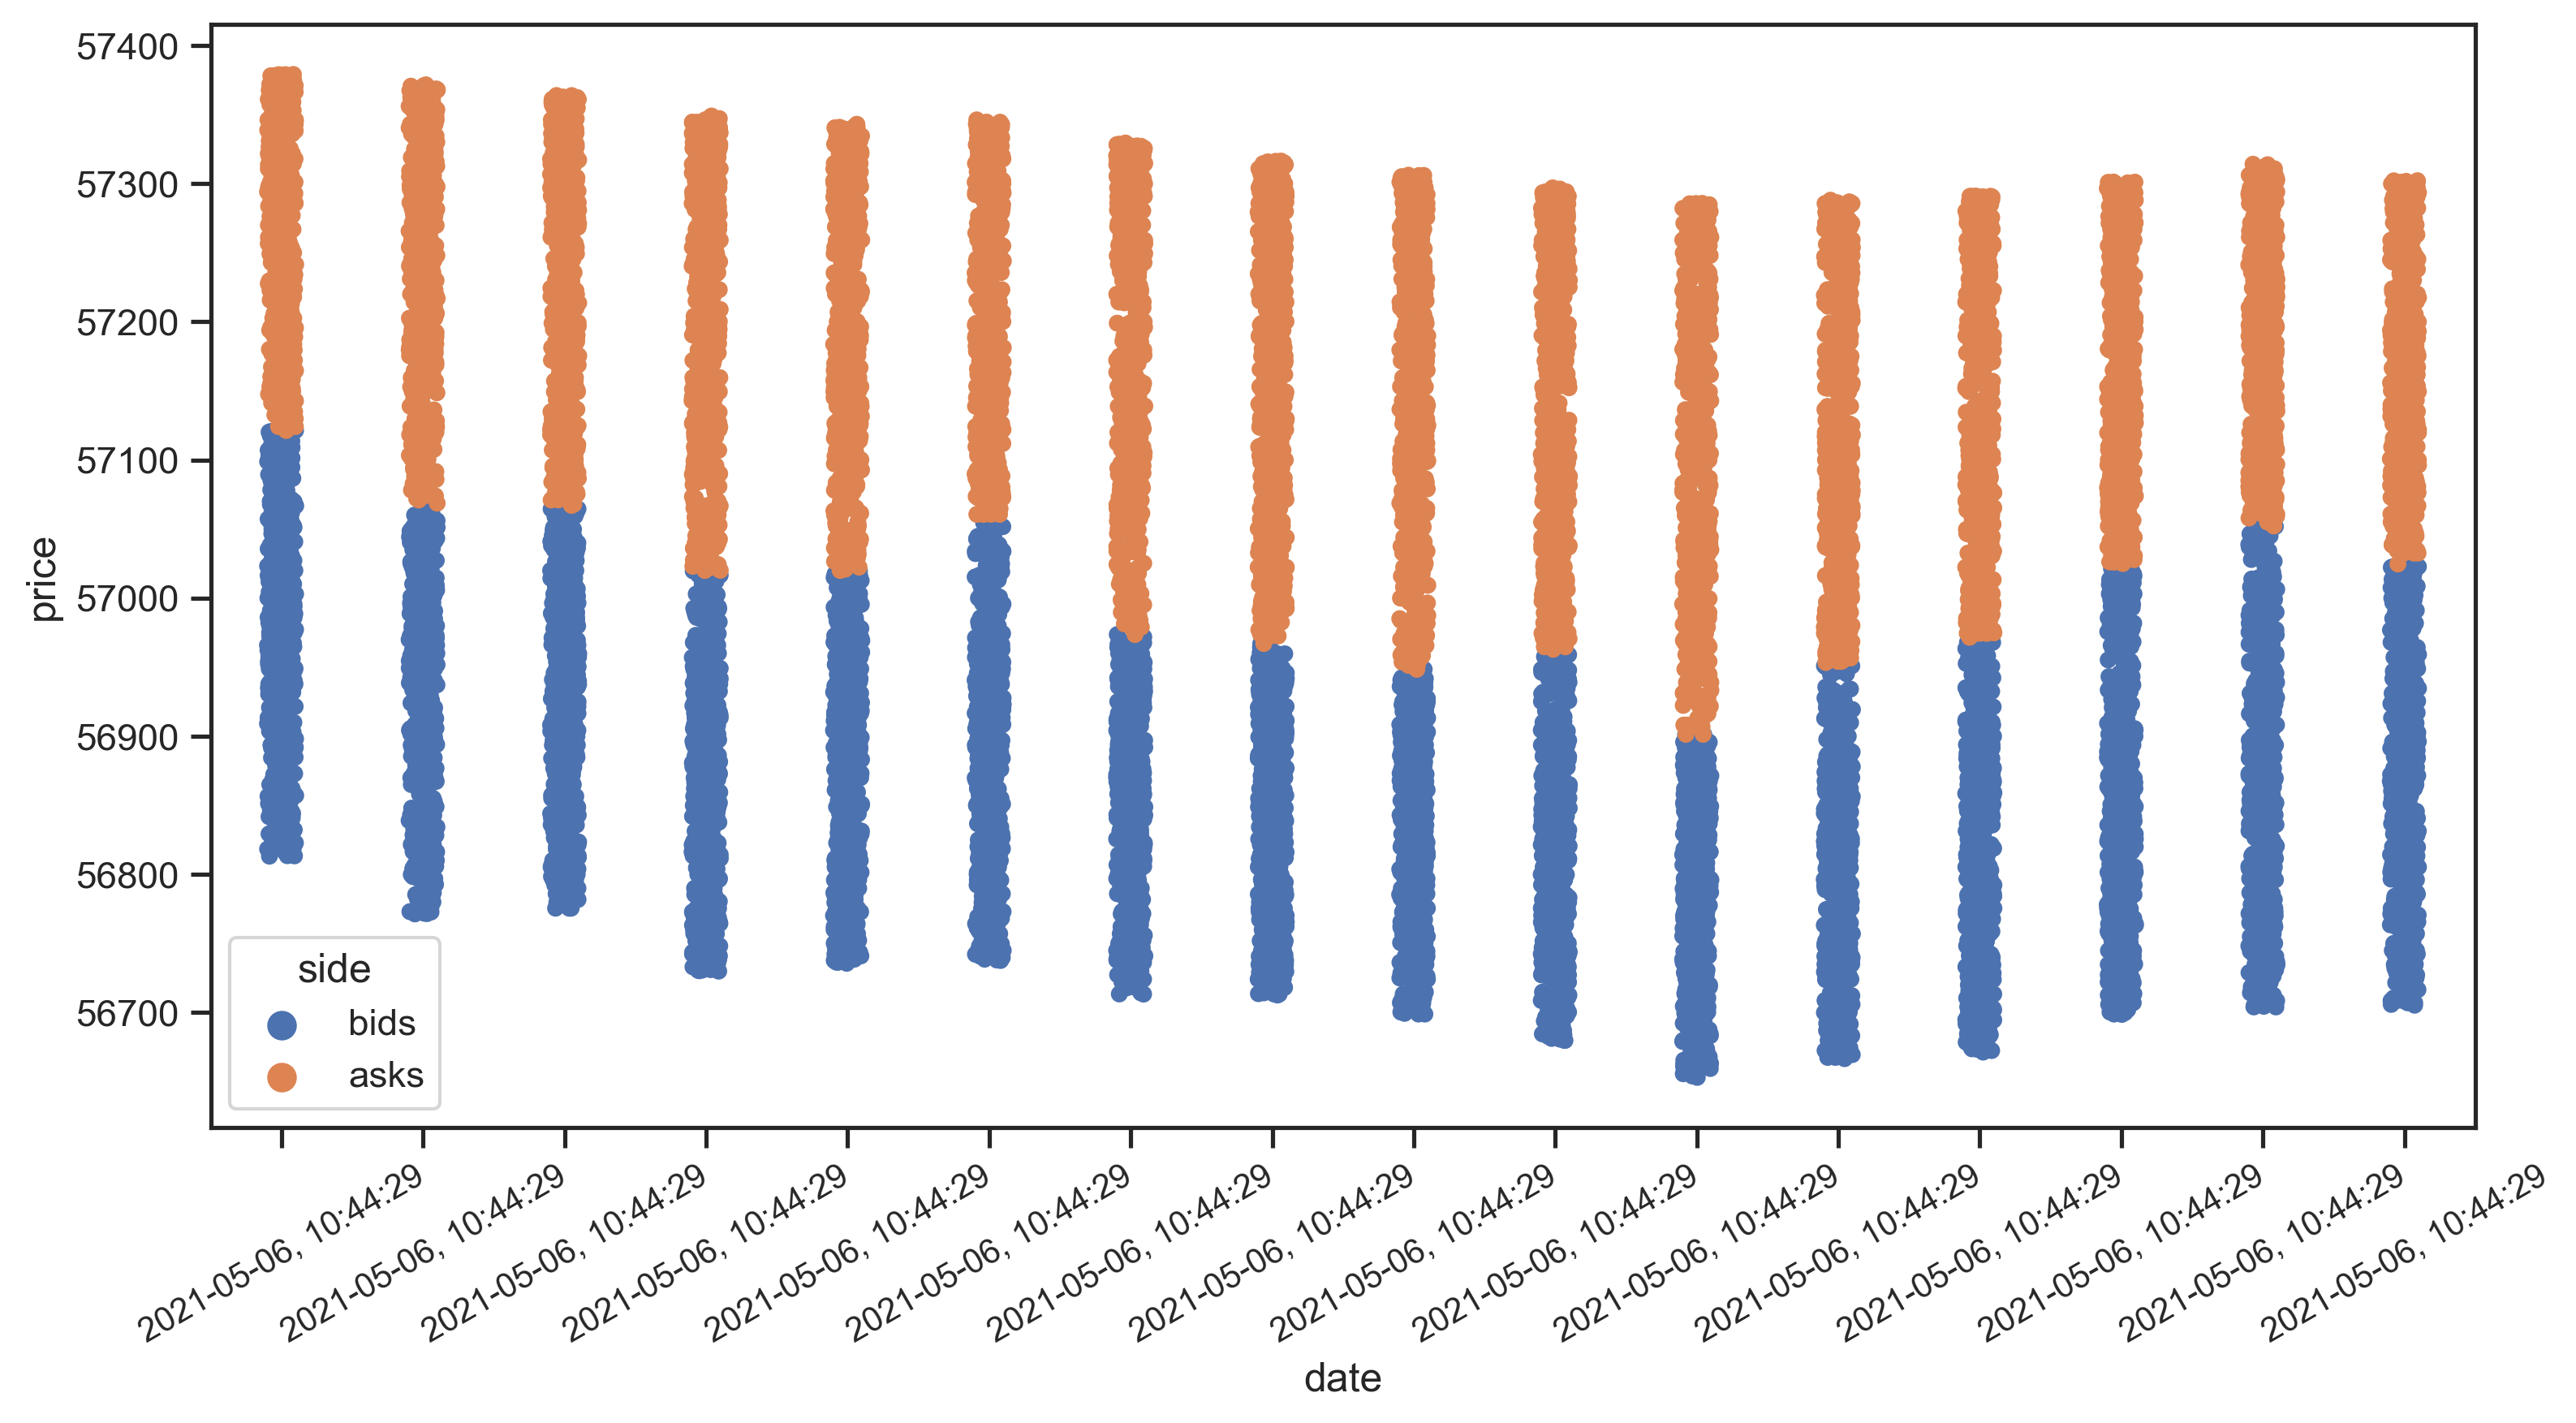

In [15]:
sns.set(rc={'figure.figsize':(12, 6), "figure.dpi":300, 'savefig.dpi':300})
sns.set_context('notebook')
sns.set_style("ticks")

idx = list(range(0, 499)) + list(range(5000, 5499))

jitterPlot(0, 16, indices = idx)

## 2.2. ACF

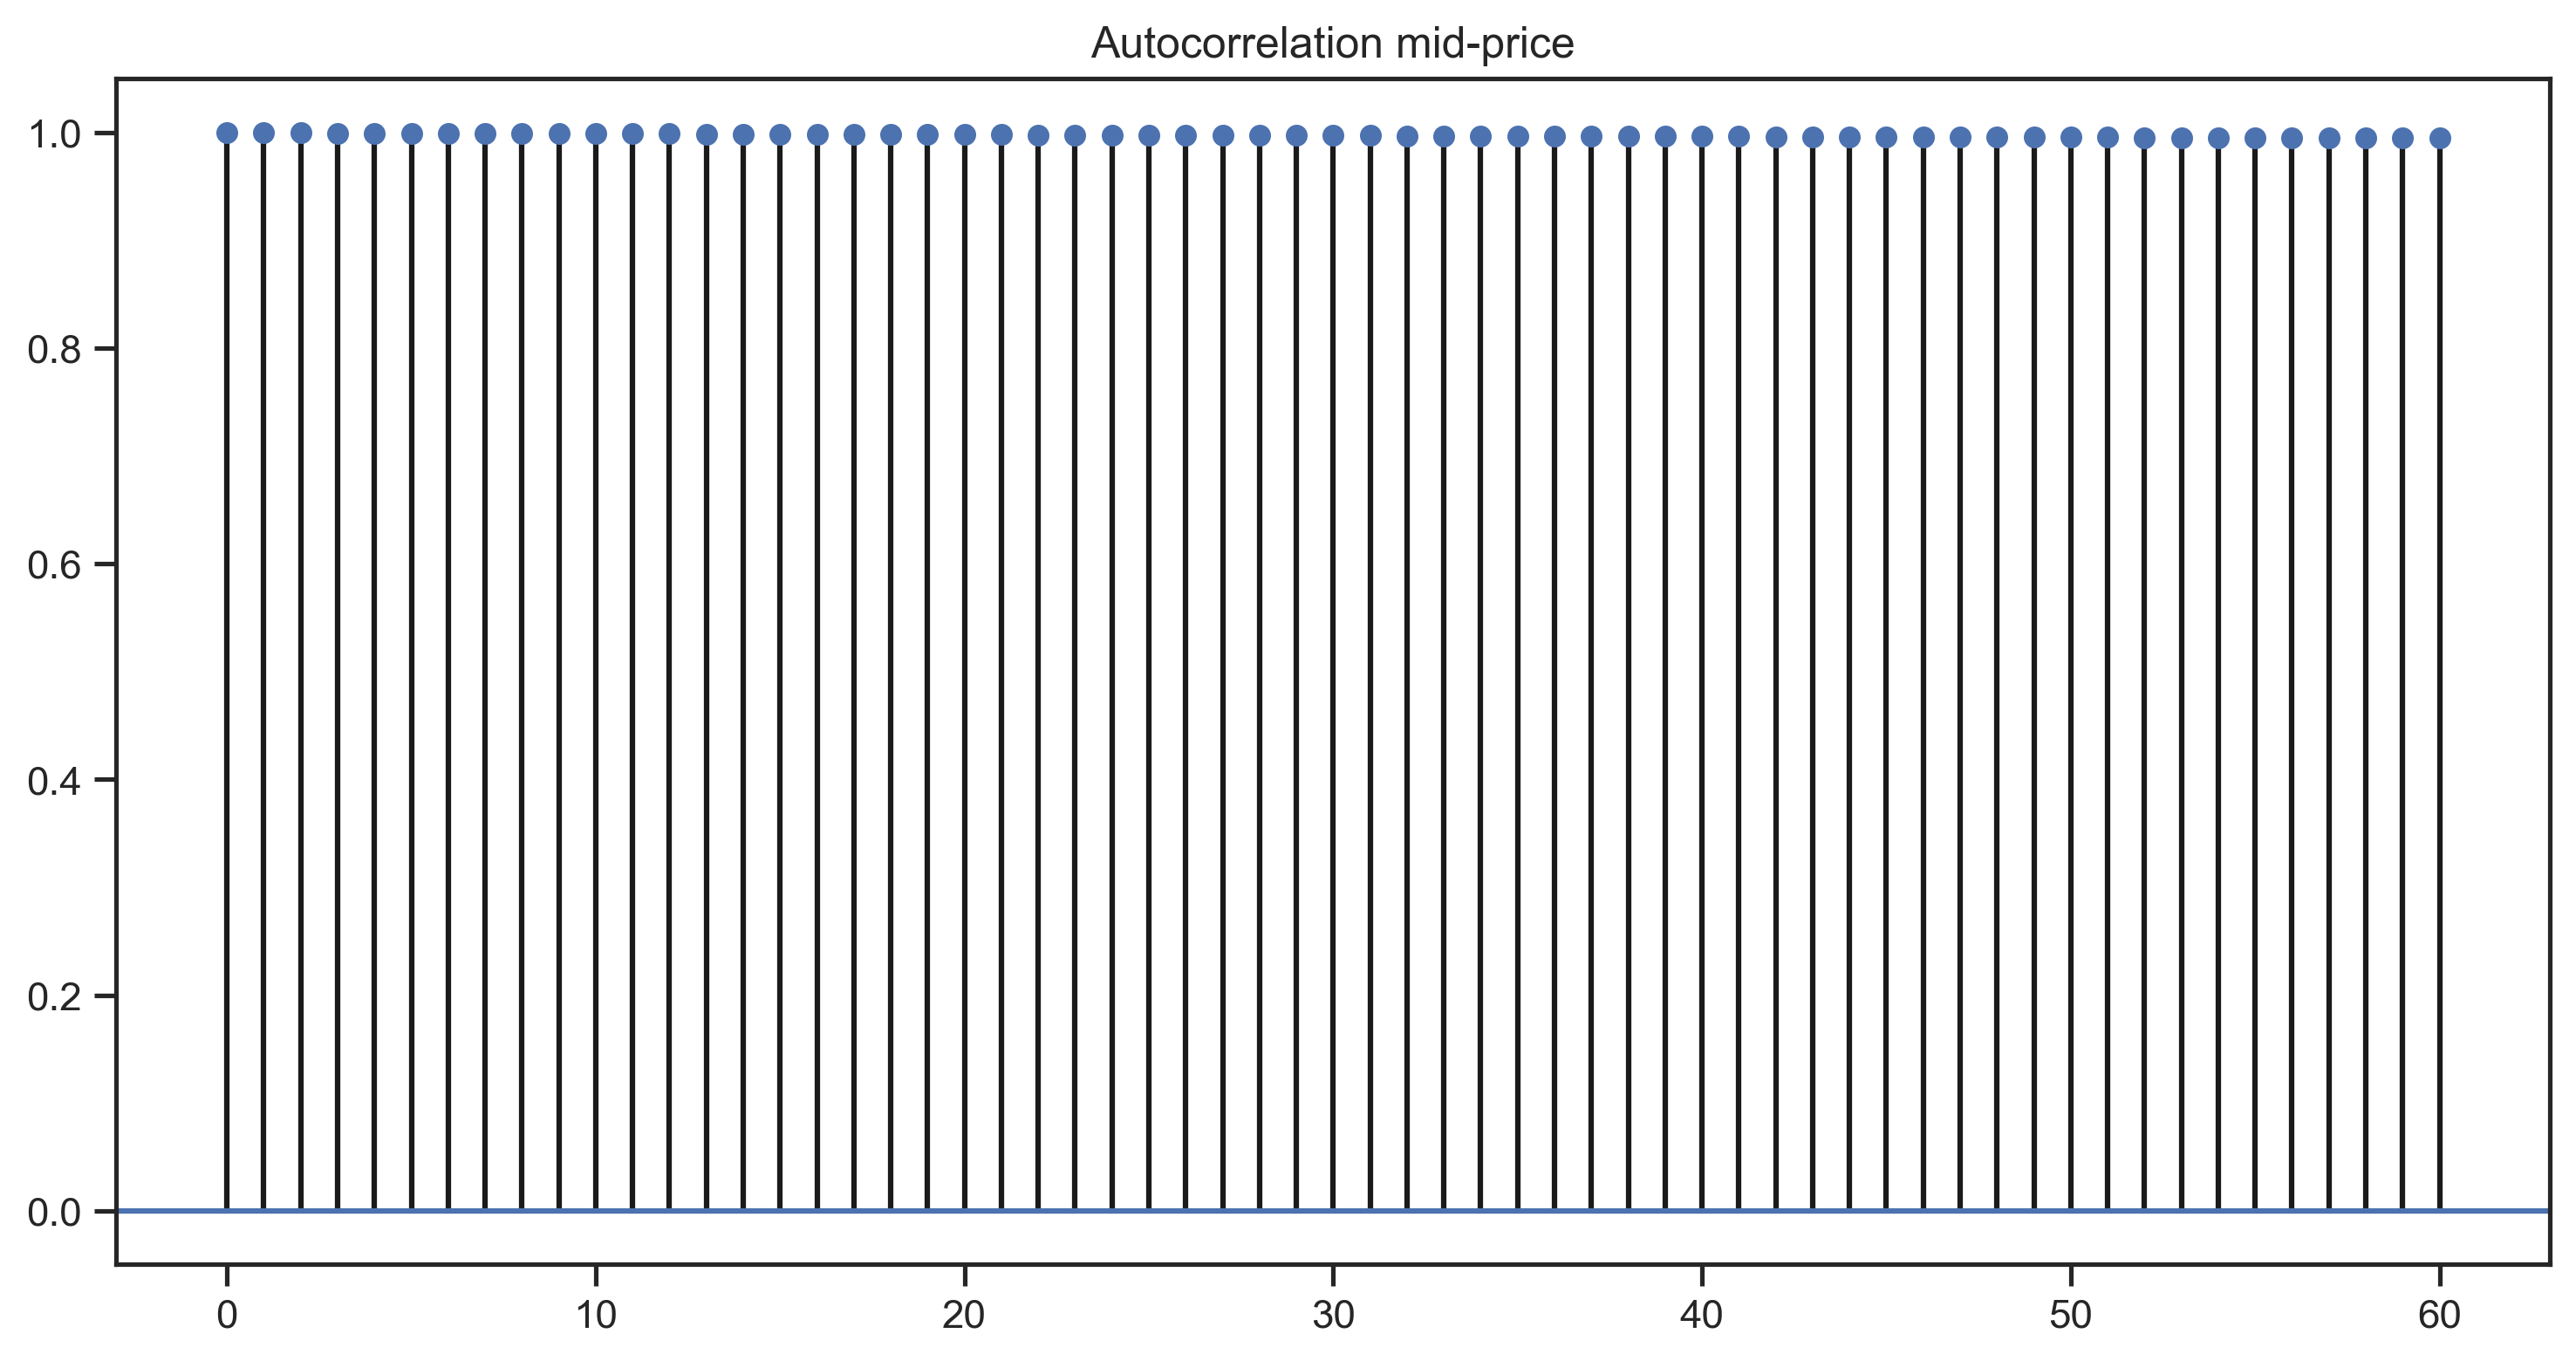

In [36]:
# Representación de las variables
# fig, ax = plt.subplots(figsize=(9, 3))
plot_acf(midprice['MPT0'], lags = 60, title = 'Autocorrelation mid-price', alpha = None);

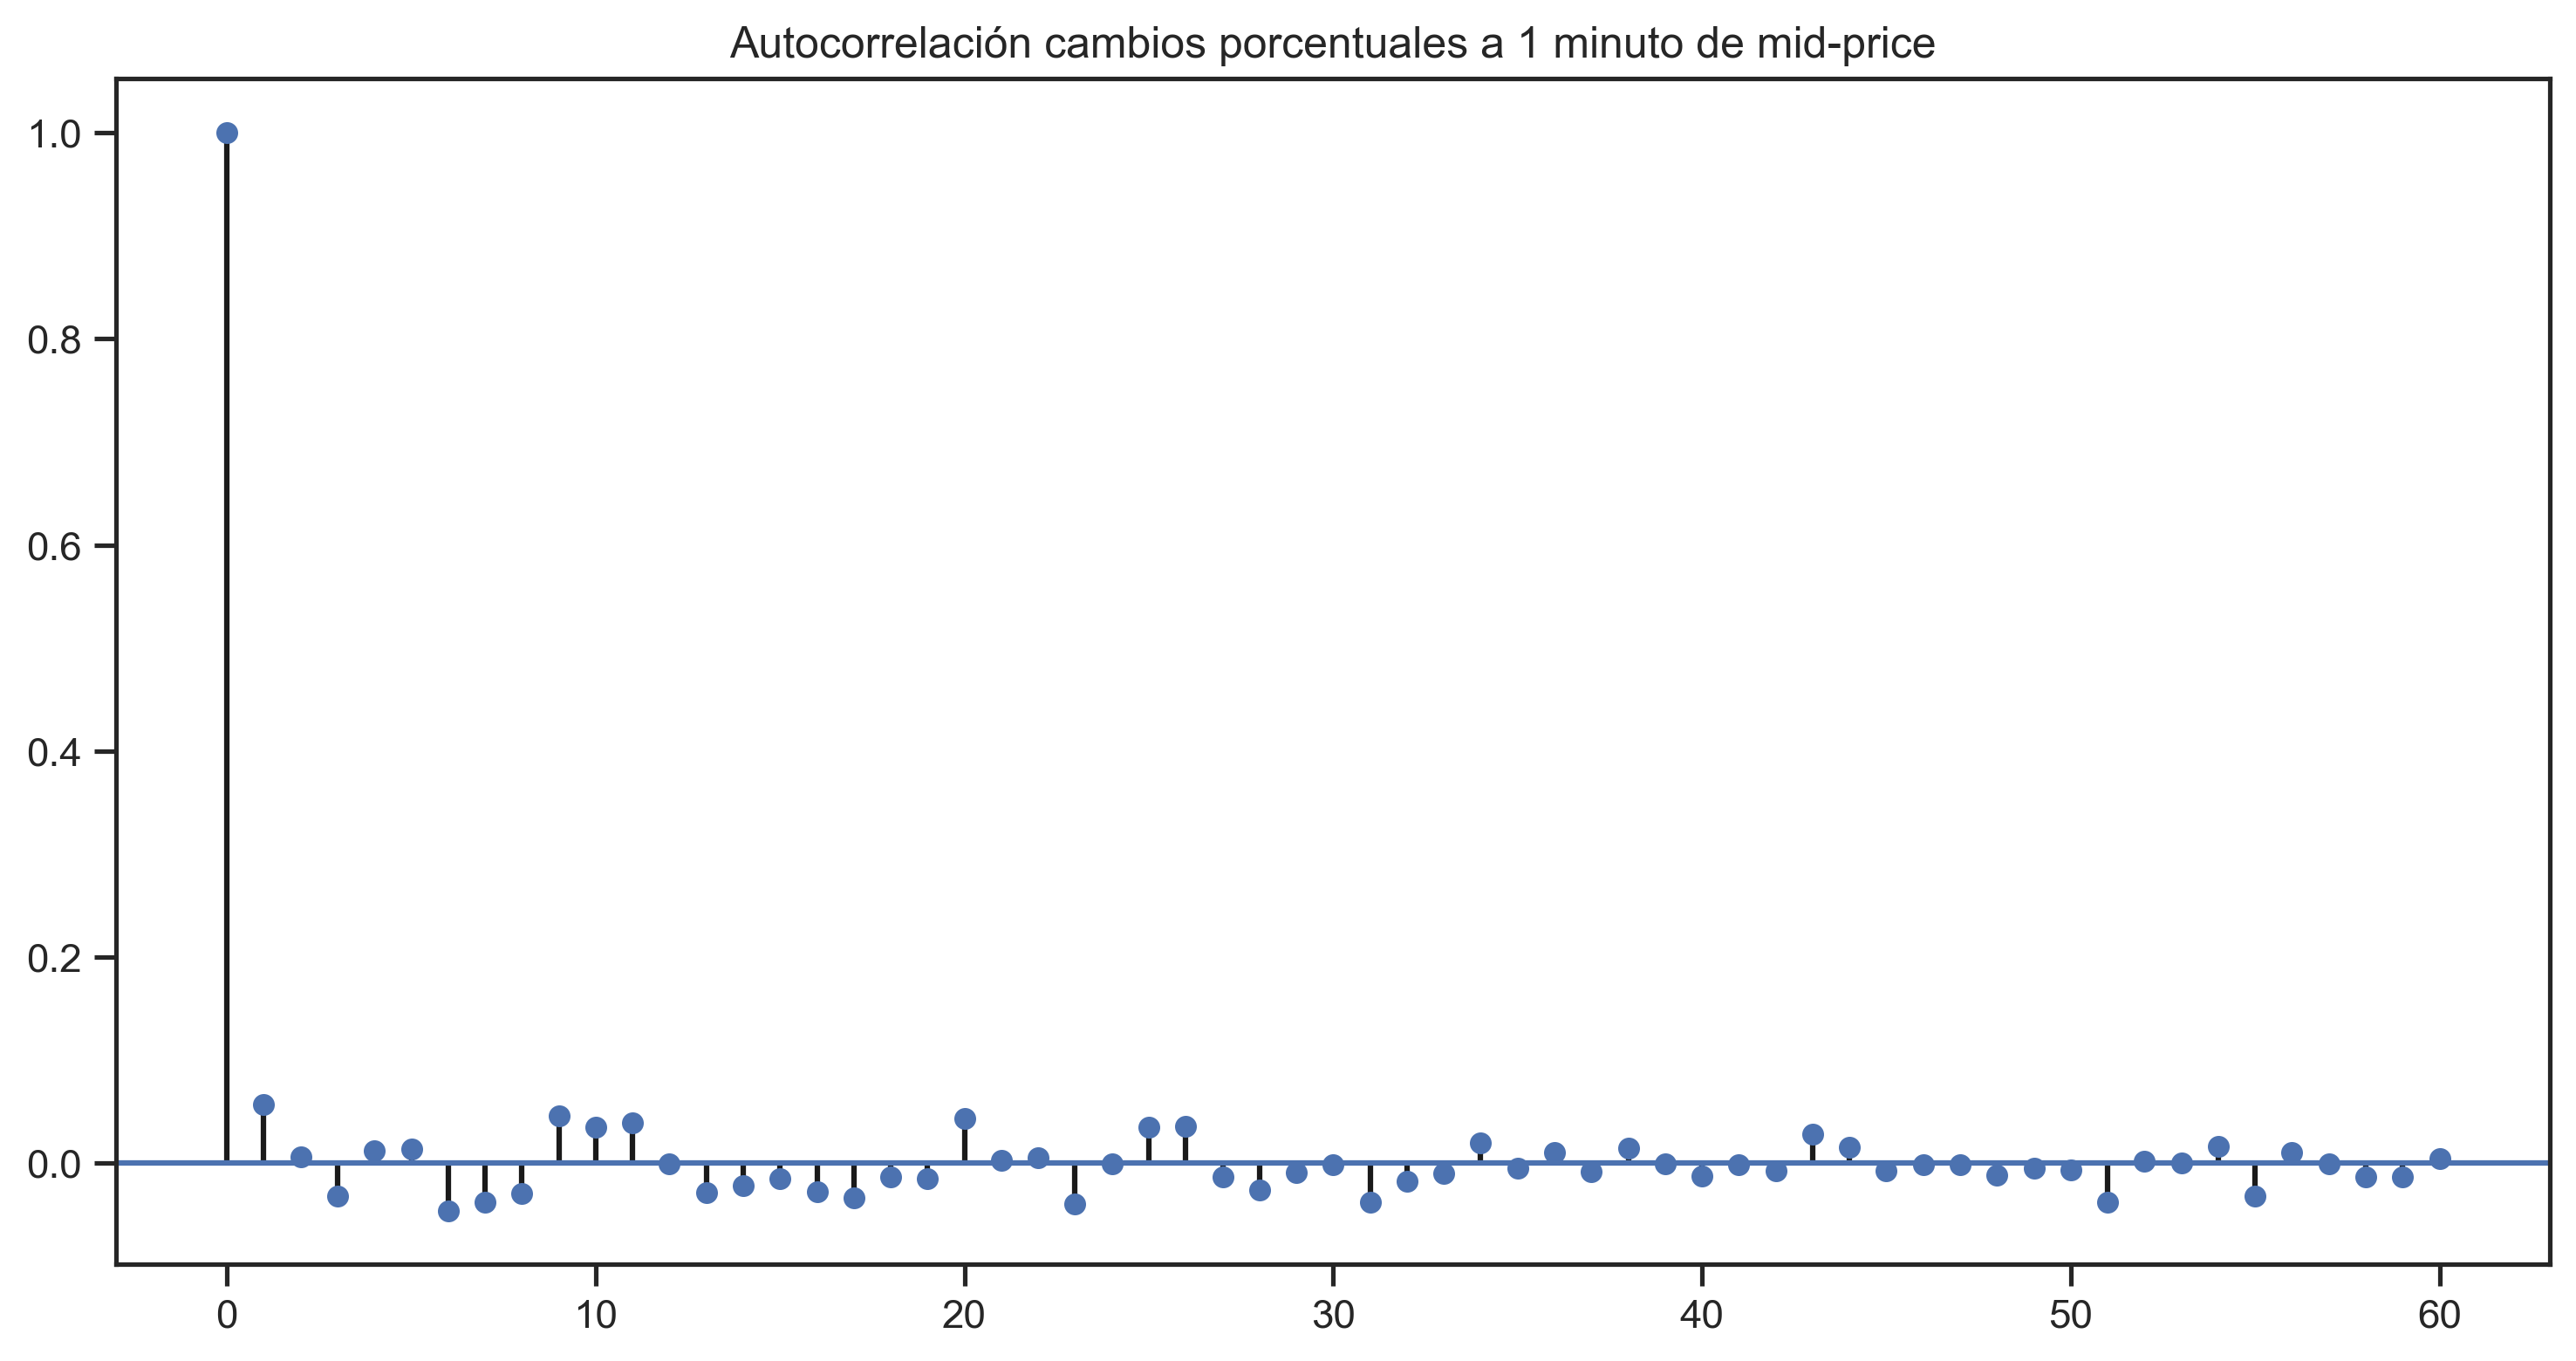

In [18]:
# Representación de las variables
plt.figsize=(10, 15)
plot_acf(SubSetMidPrice['PctChange_1minute'][1:], lags = 60, title = 'Autocorrelación cambios porcentuales a 1 minuto de mid-price',
         alpha = None);

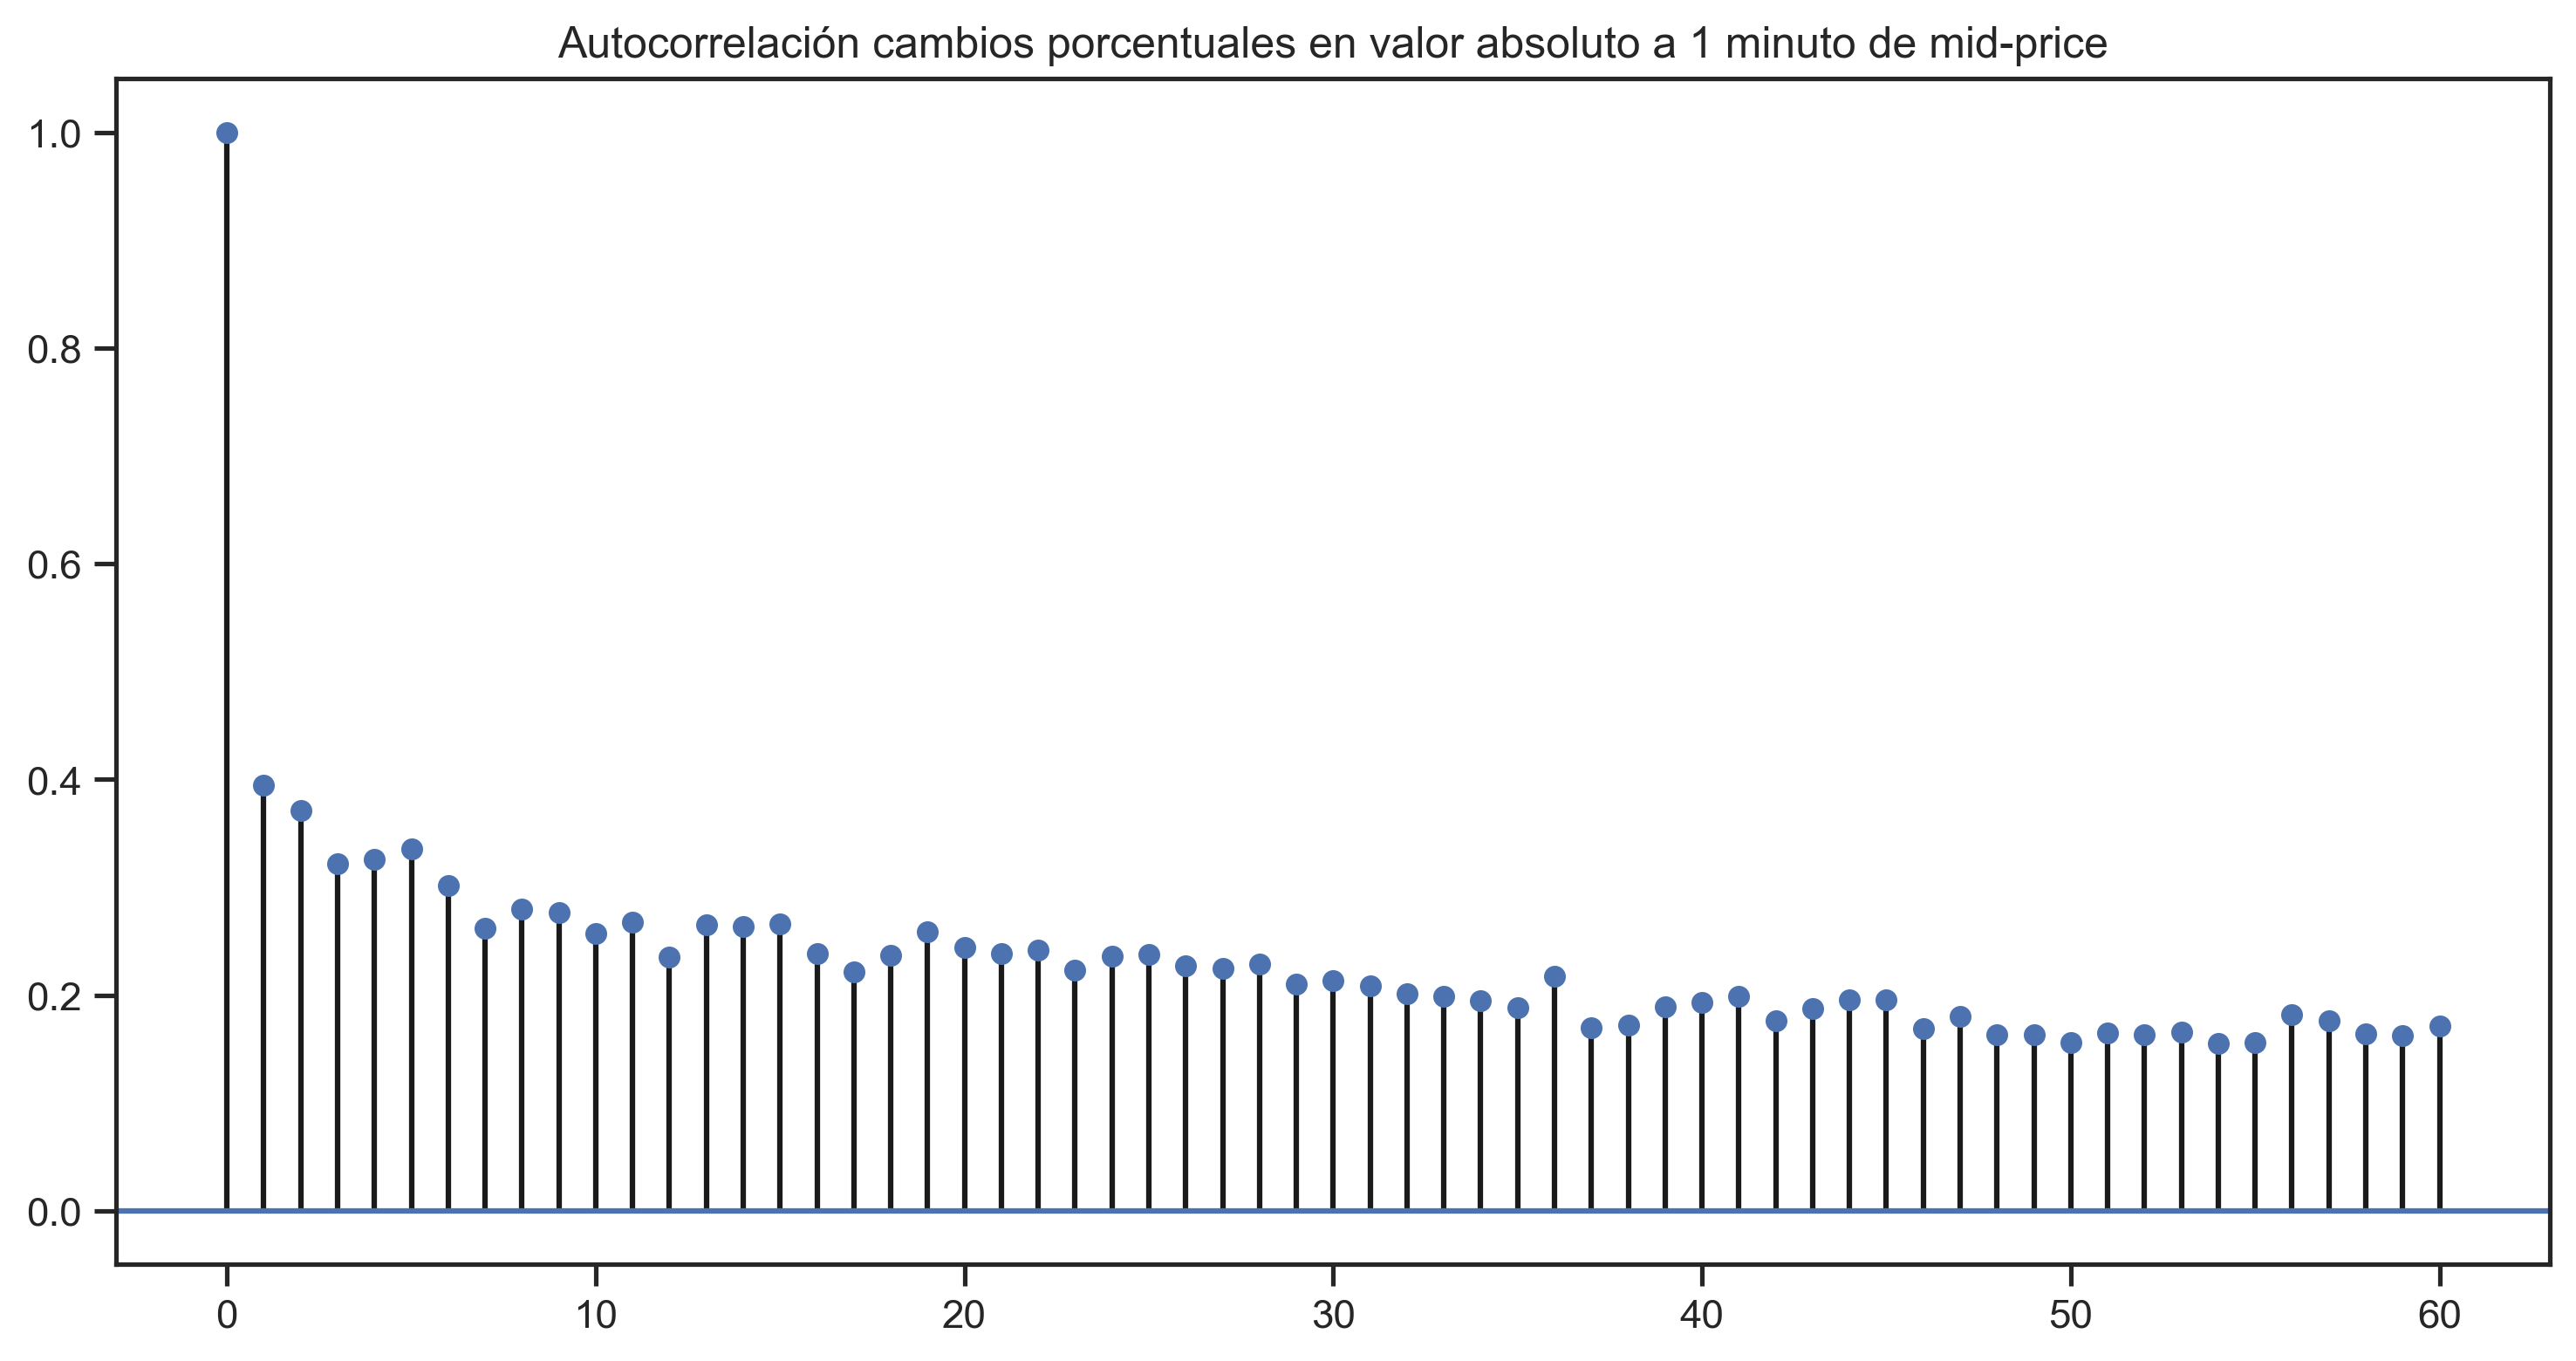

In [37]:
# Representación de las variables
plt.figsize=(10, 15)
plot_acf(abs(SubSetMidPrice['PctChange_1minute'][1:]), lags = 60, title = 'Autocorrelación cambios porcentuales en valor absoluto a 1 minuto de mid-price',
        alpha = None);

## 2.3. PACF

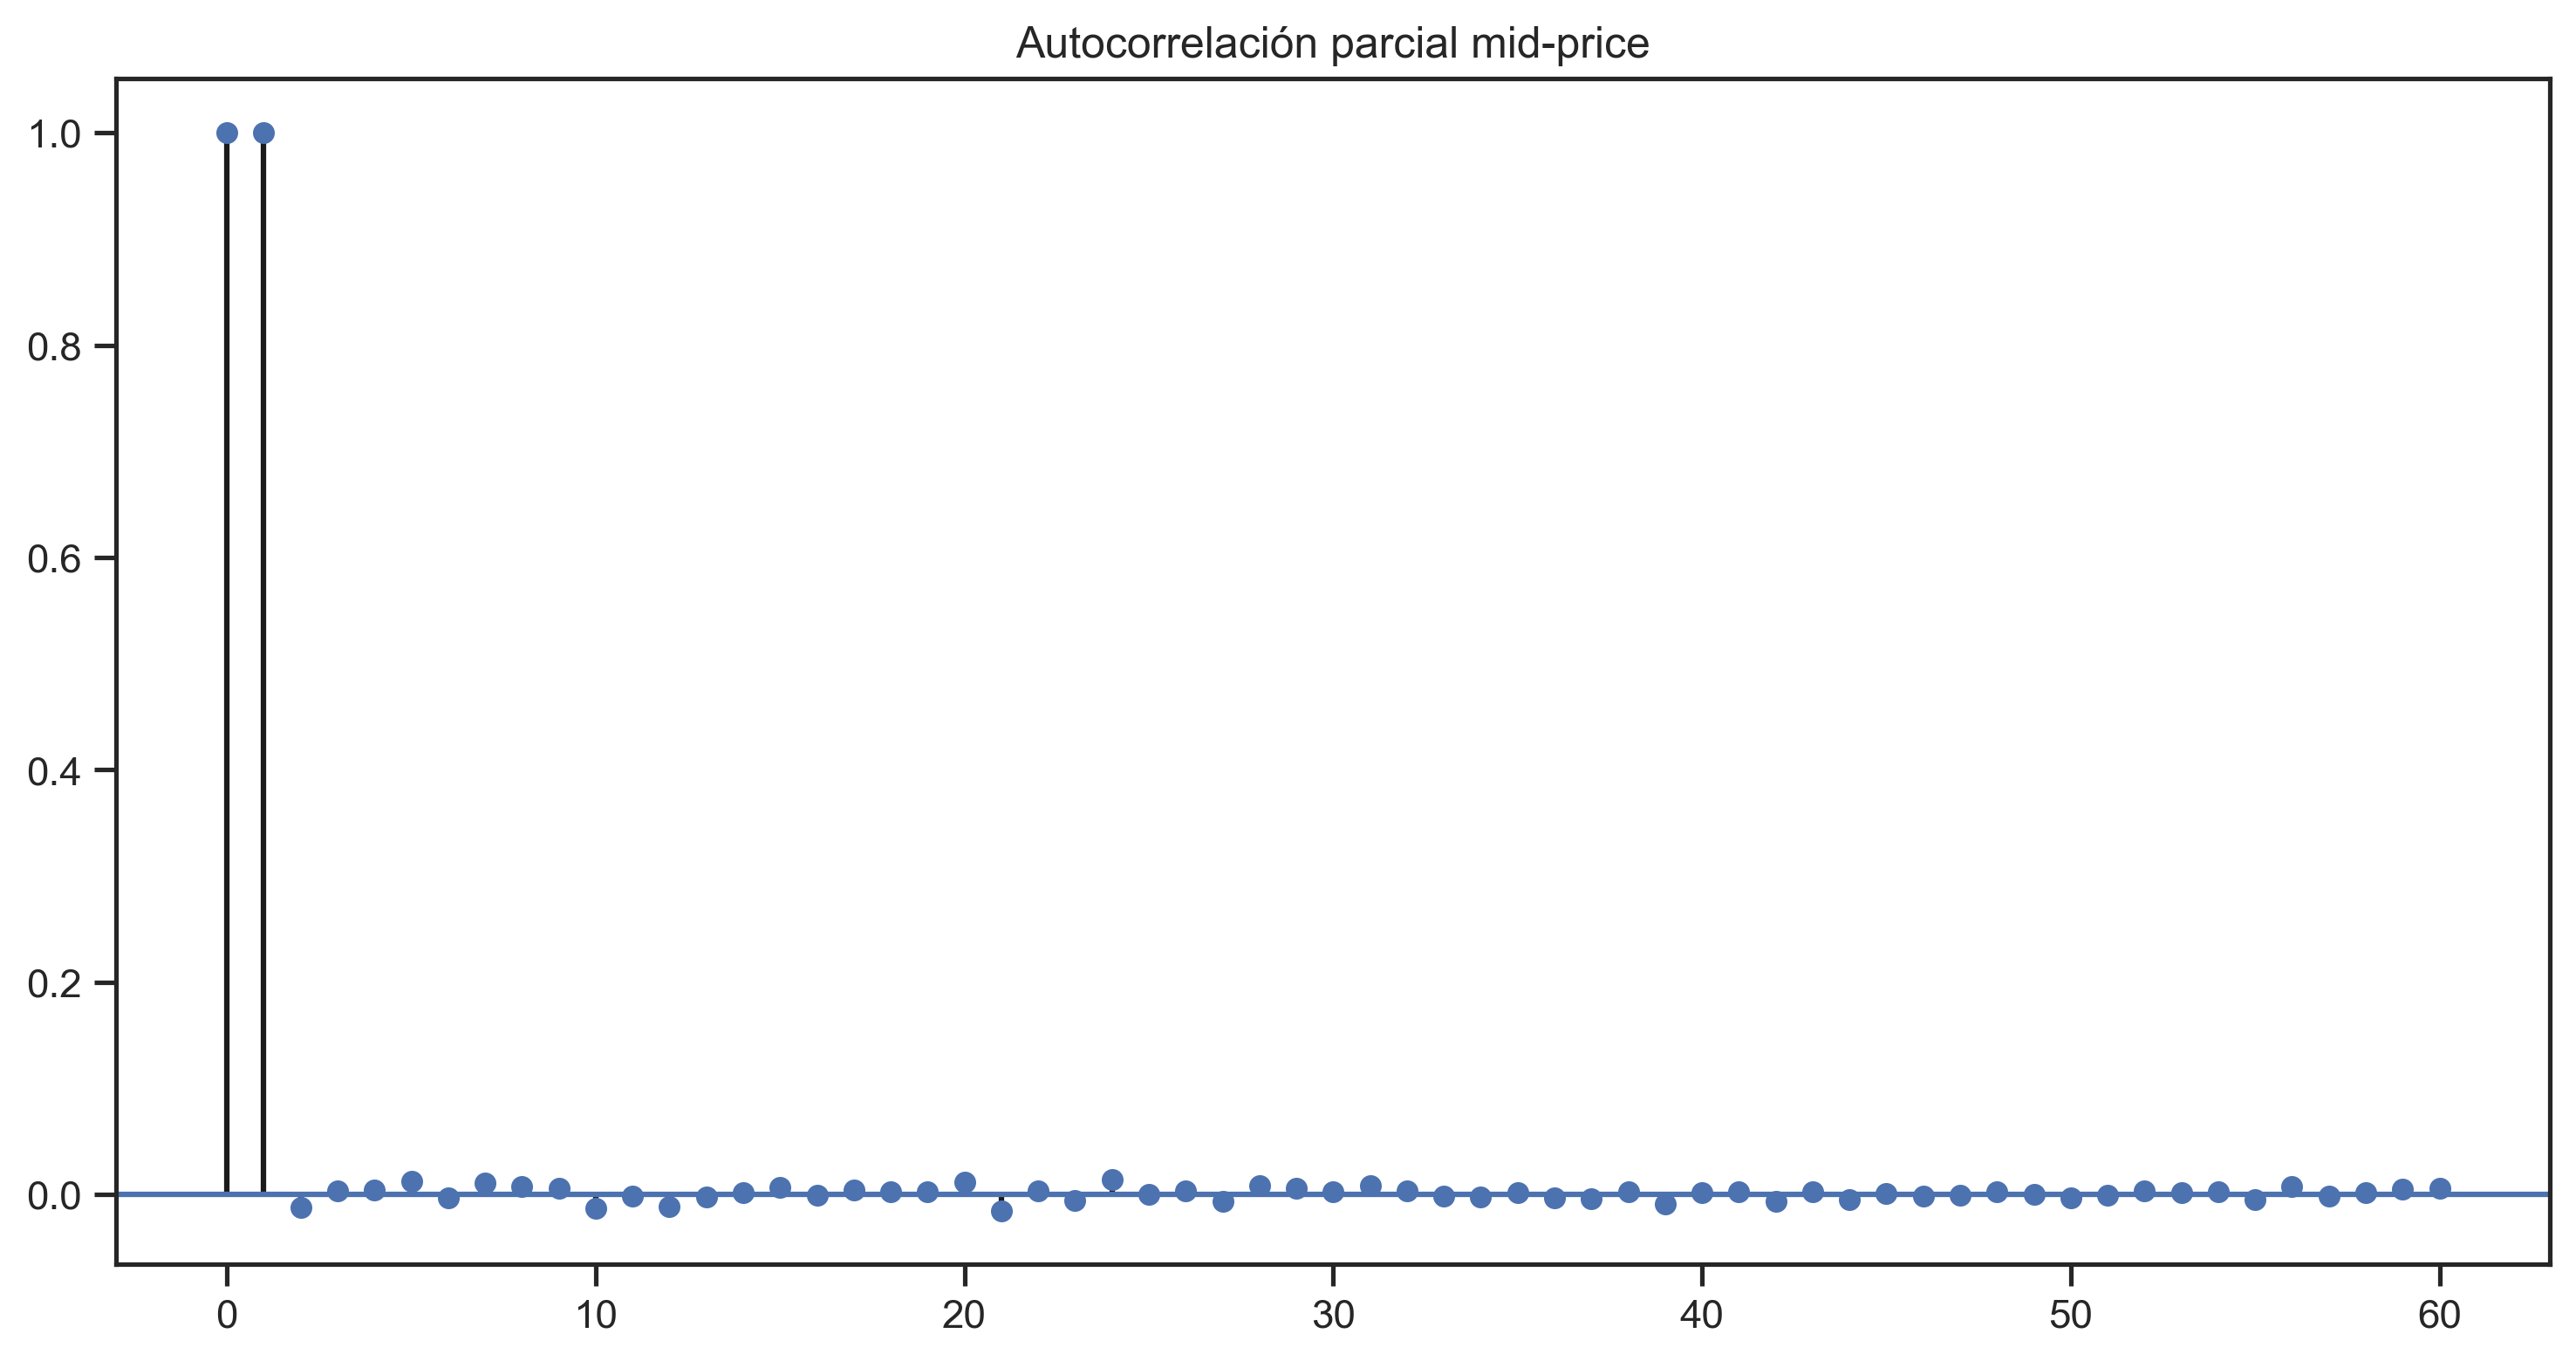

In [38]:
# Representación de las variables
plt.figsize=(10, 15)
plot_pacf(midprice['MPT0'], lags = 60, title = 'Autocorrelación parcial mid-price', alpha = None);

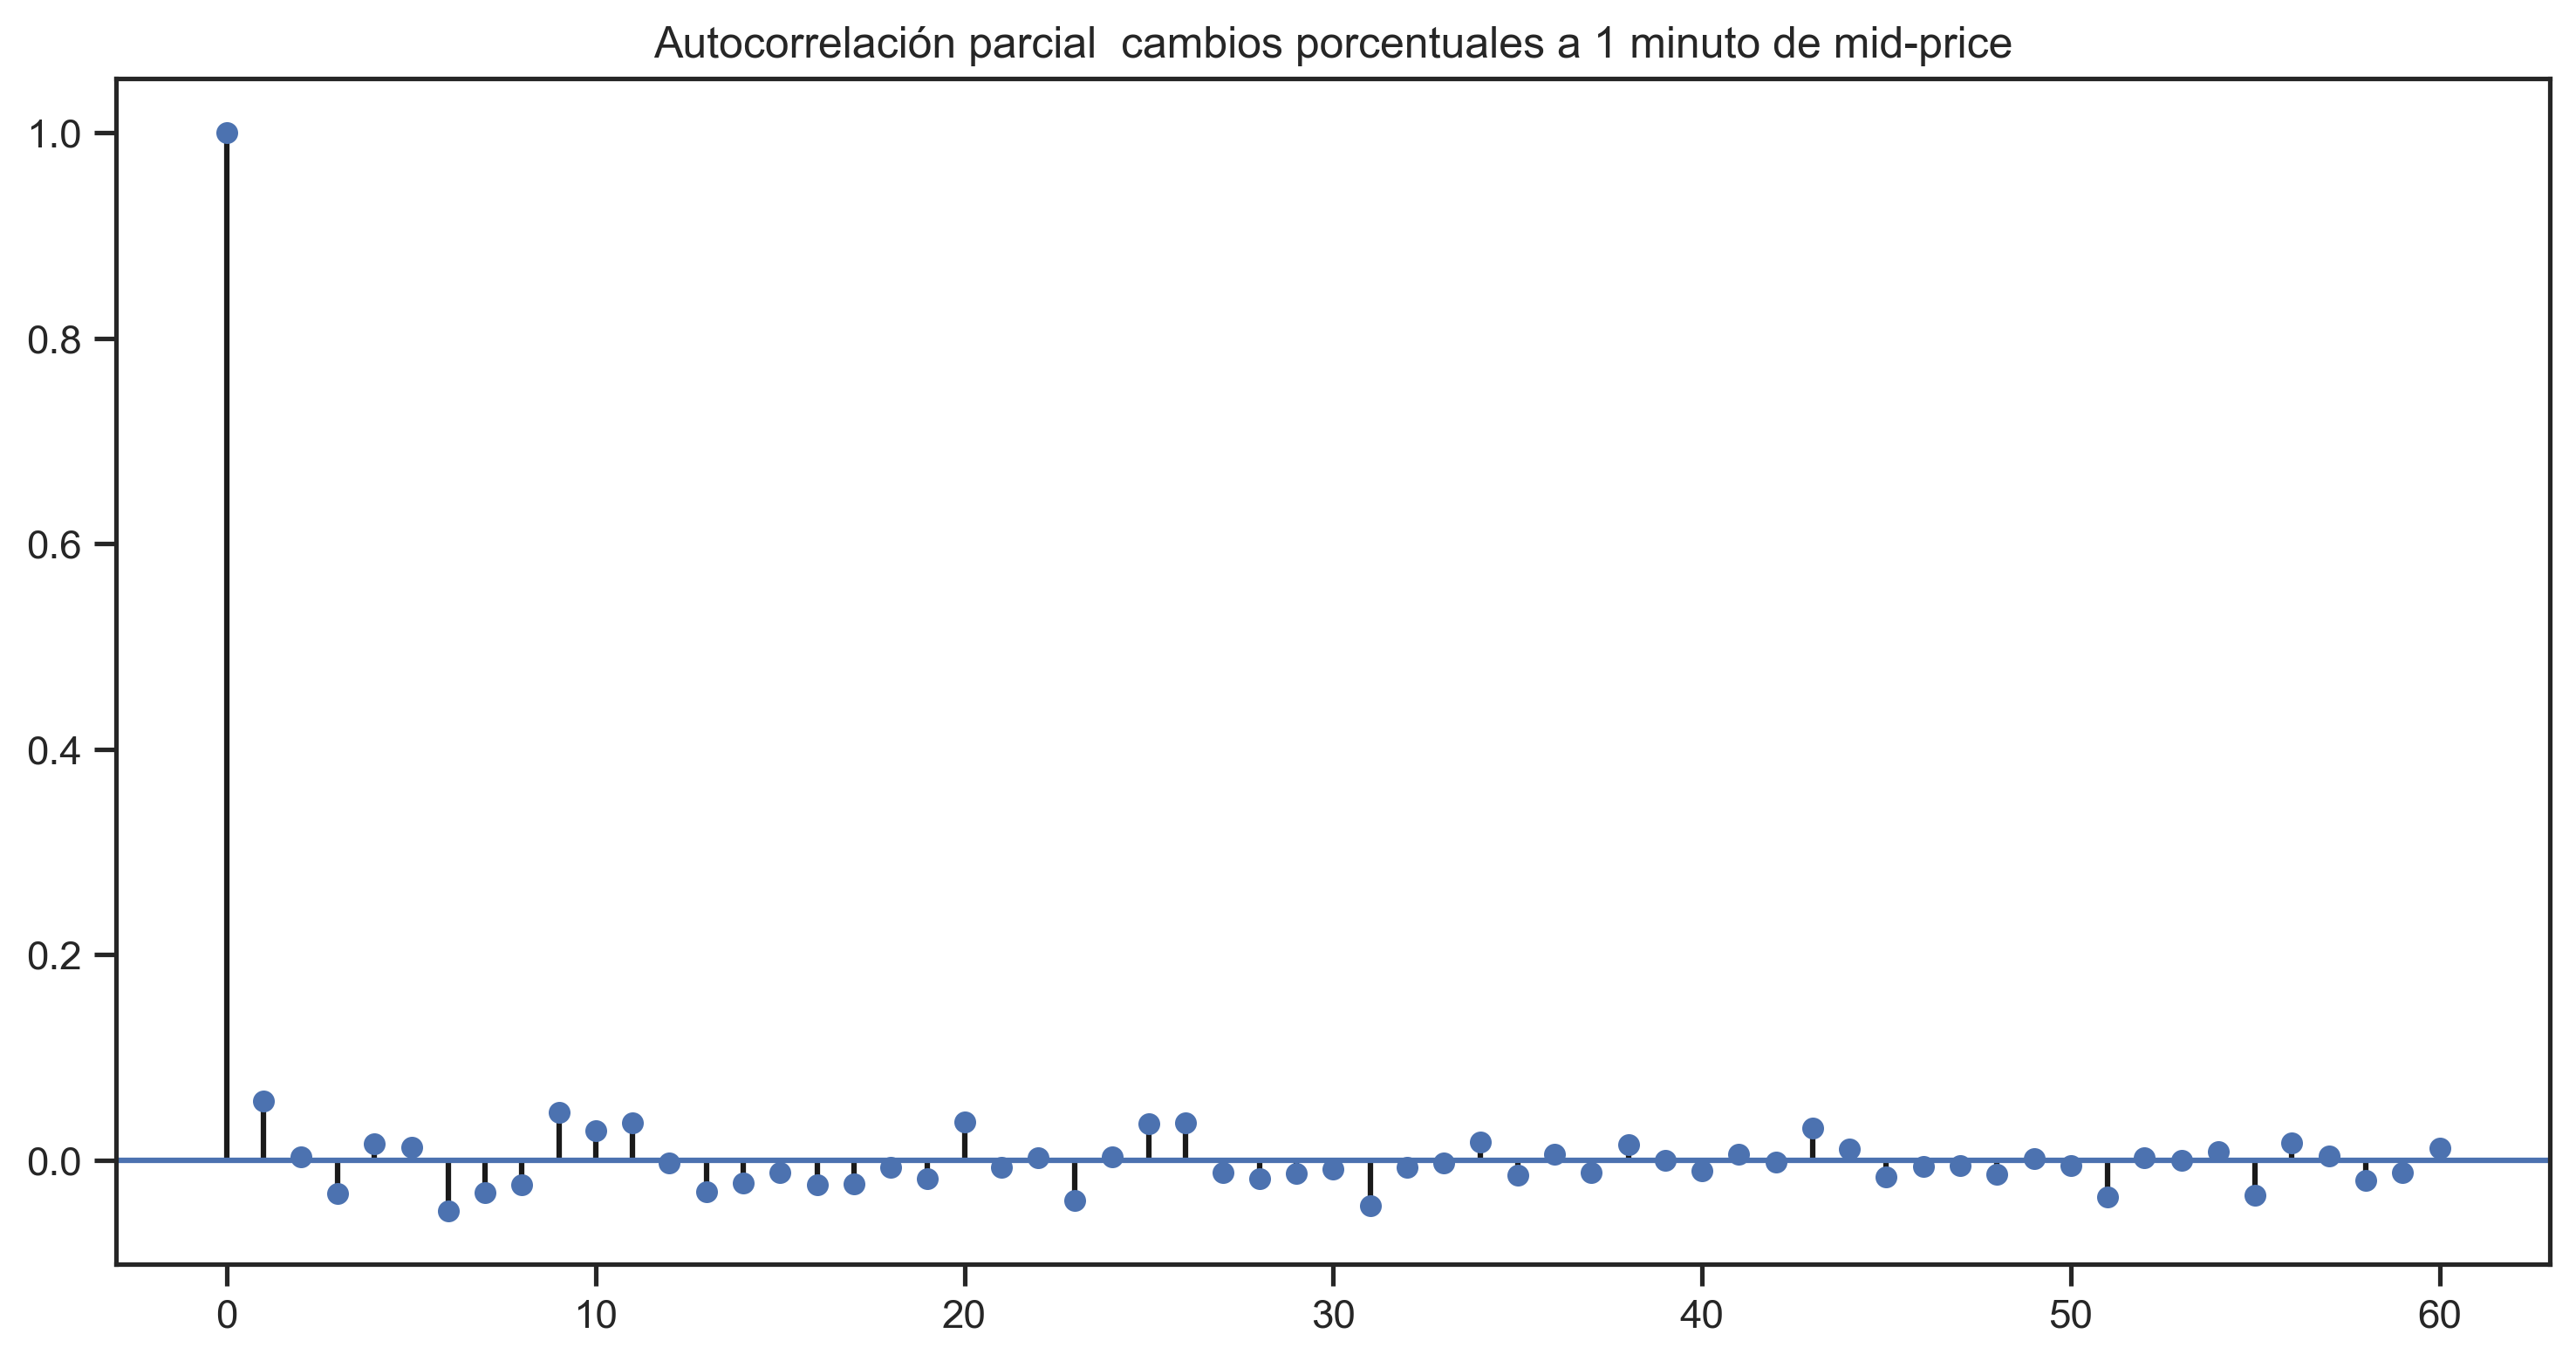

In [39]:
# Representación de las variables
plt.figsize=(10, 15)
plot_pacf(SubSetMidPrice['PctChange_1minute'][1:], lags = 60, title = 'Autocorrelación parcial  cambios porcentuales a 1 minuto de mid-price',
         alpha = None);

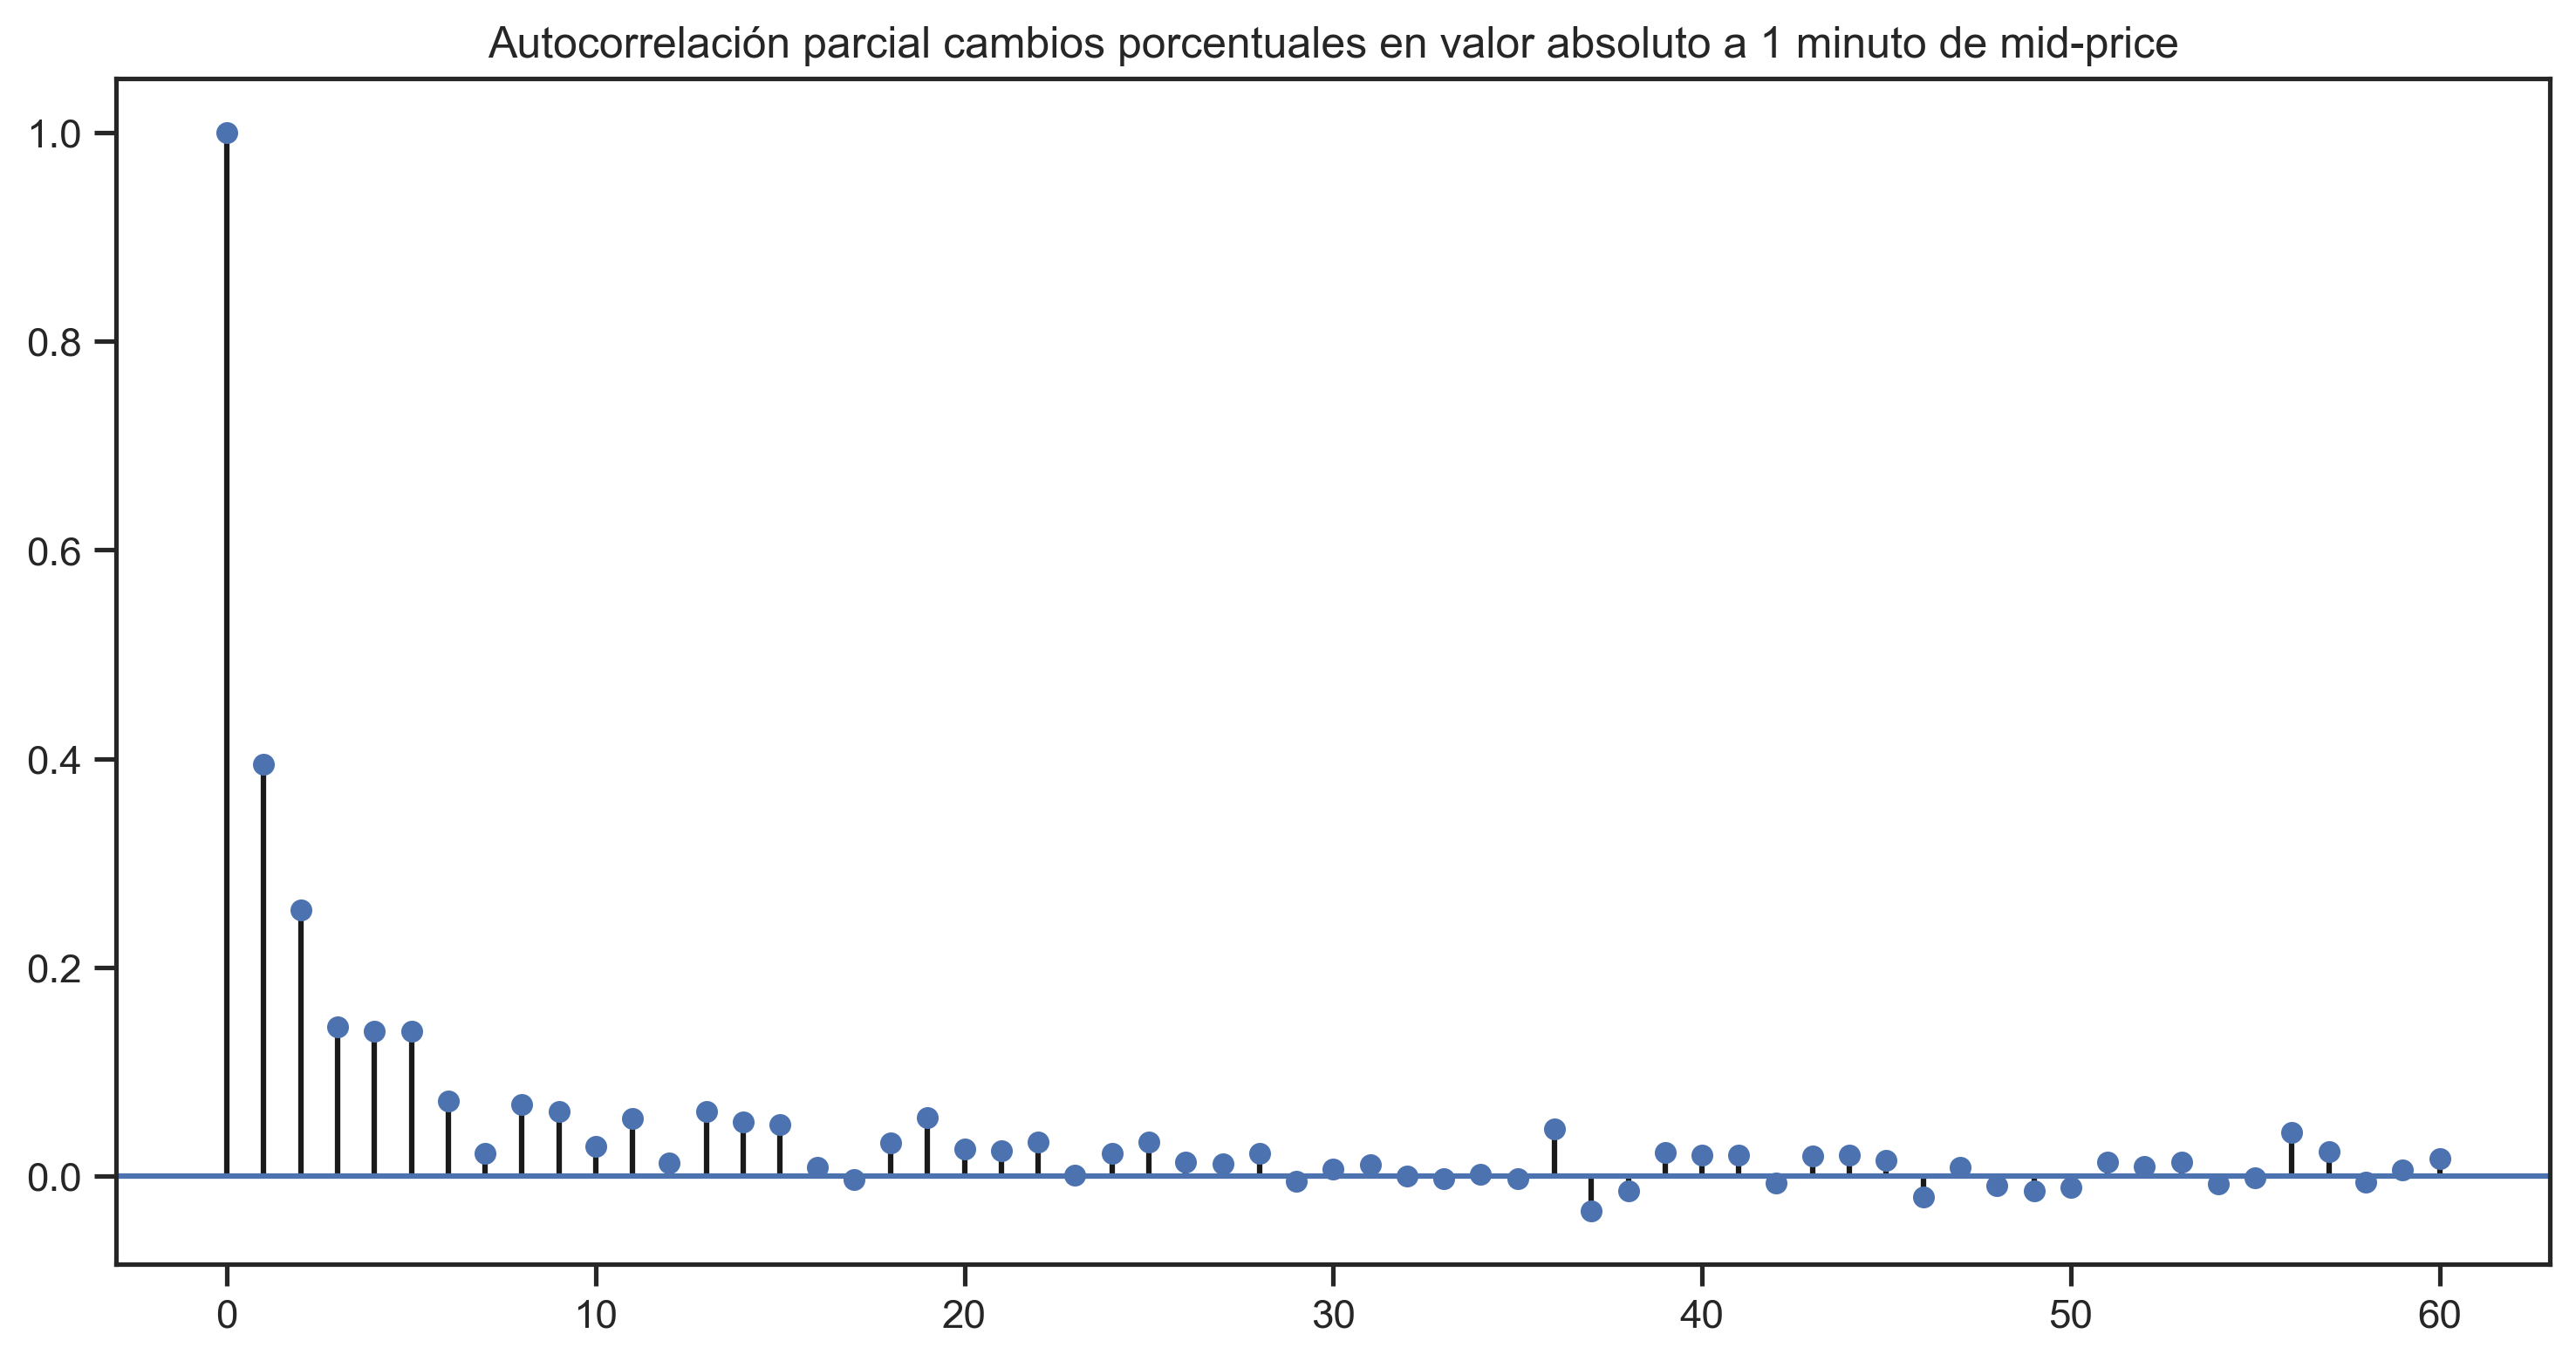

In [40]:
# Representación de las variables
plt.figsize=(10, 15)
plot_pacf(abs(SubSetMidPrice['PctChange_1minute'][1:]), lags = 60, title = 'Autocorrelación parcial cambios porcentuales en valor absoluto a 1 minuto de mid-price',
         alpha = None);

## 2.4. Correlaciones

In [69]:
df = pd.read_csv('datos/CrudeDatos2.csv')

### Bids

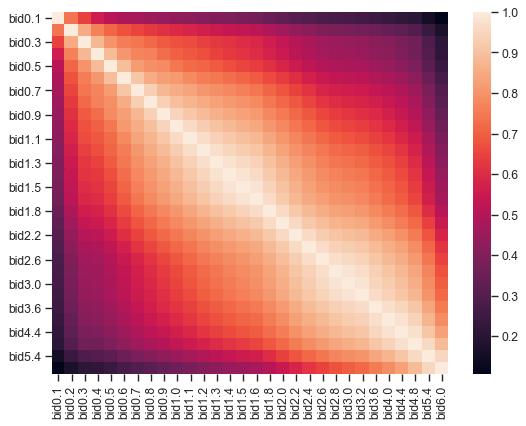

In [39]:
plt.figure(figsize=(8, 6), dpi=80)

corrMatrix = df.iloc[:, 2:32].corr()
sns.heatmap(corrMatrix)

### Asks

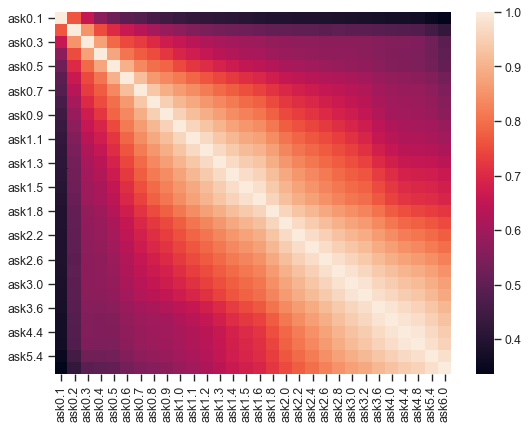

In [40]:
plt.figure(figsize=(8, 6), dpi=80)

corrMatrix = df.iloc[:, 54:84].corr()
sns.heatmap(corrMatrix)

### BidSlp

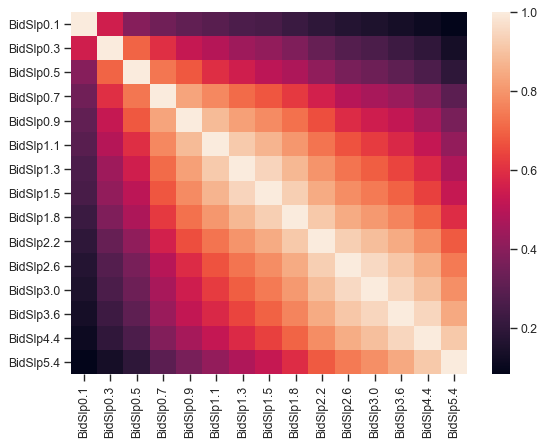

In [41]:
plt.figure(figsize=(8, 6), dpi=80)

corrMatrix = df.iloc[:, 34:49].corr()
sns.heatmap(corrMatrix)

### AskSlp

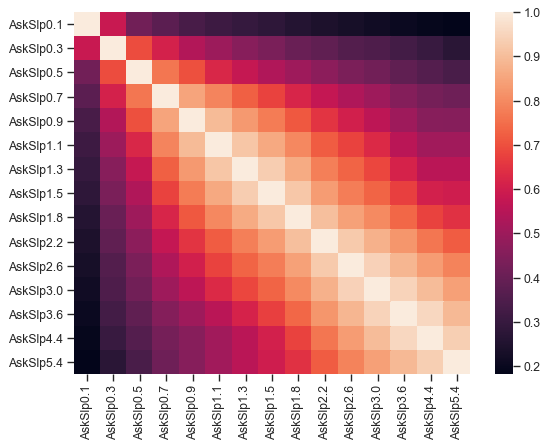

In [42]:
plt.figure(figsize=(8, 6), dpi=80)

corrMatrix = df.iloc[:, 86:101].corr()
sns.heatmap(corrMatrix)